In [2]:
import pandas as pd
# pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 500

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

### Ввод данных

In [3]:
data = pd.read_csv('../../NewsParser/data/DATA_MANY_TOPICS.csv')
data = data[~((data.topic == 'forces') & (data.url.str.contains('https://www.gazeta.ru/')))]

In [4]:
data.drop('index', 1, inplace=True)
data.drop(data[data.topic == 'football'].sample(25000).index, inplace=True)
data.drop(data[data.topic == 'hockey'].sample(5000).index, inplace=True)
data.drop(data[data.topic == 'business'].sample(12000).index, inplace=True)
data.drop(data[data.topic == 'politics'].sample(5000).index, inplace=True)

In [5]:
data.sample(5)

,text,title,topic,url
149172,"Директор казанского ""Динамо"" Сергей Чернышов о...","Сергей Чернышов: ""Никакого давления со стороны...",volleyball,http://www.sport-express.ru/volleyball/russia/...
109871,Кости человека стали легкими и хрупкими из-за ...,Антропологи объяснили хрупкость костей человека,science,https://lenta.ru/news/2014/12/23/bones/
23935,\n Импорт товаров из стран дальнего зарубежья...,\n Минэкономразвития: импор...,business,http://www.vedomosti.ru/business/news/2013/04/...
24224,\n \n Microsoft регулярно замеряет уровень пи...,\n Пиратов в России меньше ...,technologies,http://www.vedomosti.ru/technology/articles/20...
128157,ЦСКА в гостевом матче регулярного чемпионата Е...,"ЦСКА проиграл ""Дарюшафаке"" Блатта",basketball,http://www.sport-express.ru/basketball/eurolea...


In [6]:
print('Number of news:', len(data))

Number of news: 133529


In [7]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


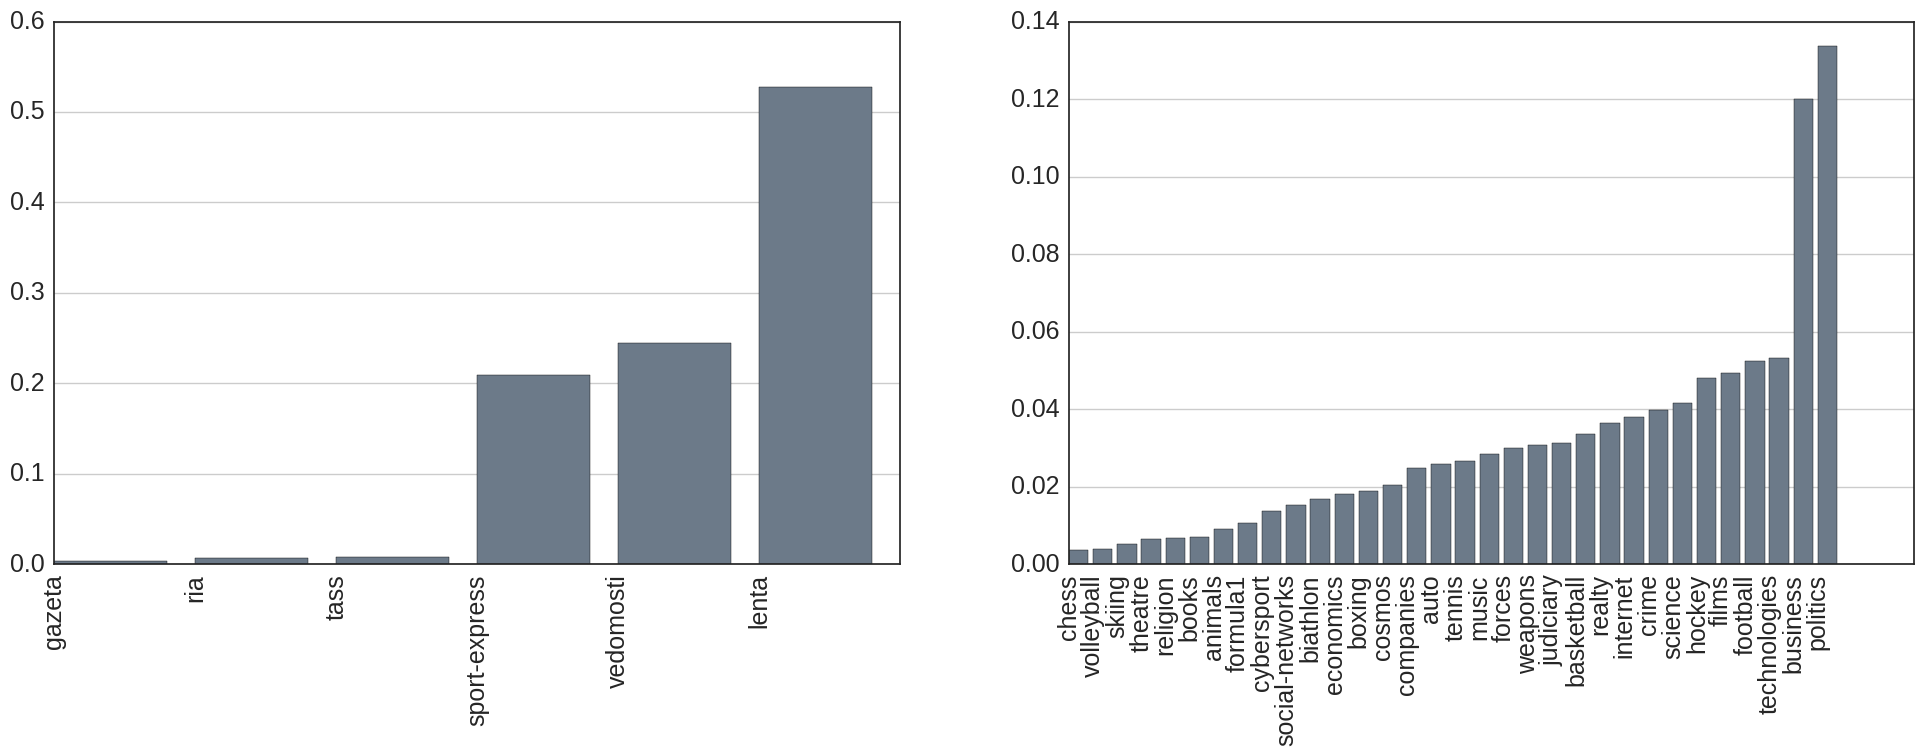

In [8]:
topics_freq = data.topic.value_counts(normalize=True, ascending=True)
media_freq = data.url.apply(lambda x: x.split('/')[2].replace('www.', '').replace('.ru', '')).value_counts(normalize=True, ascending=True)

font_size=18
fig, ax = plt.subplots(1, 2, figsize=(24, 7))
ax[0].bar(range(len(media_freq)), media_freq.values, color='#6C7A89')
ax[0].set_xticks(range(len(media_freq)))
ax[0].set_xticklabels(media_freq.index, rotation=90)
ax[0].tick_params(labelsize=font_size)
ax[0].yaxis.grid()

ax[1].bar(range(len(topics_freq)), topics_freq.values, color='#6C7A89')
ax[1].set_xticks(range(len(topics_freq)))
ax[1].set_xticklabels(topics_freq.index, rotation=90)
ax[1].tick_params(labelsize=font_size)
ax[1].yaxis.grid()
fig.savefig('../docs/images/media_topi_distr.pdf', bbox_inches='tight')

In [9]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [10]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
en_sw = get_stop_words('en')
ru_sw = get_stop_words('ru')
STOP_WORDS = set(en_sw) | set(ru_sw)
STOP_WORDS = STOP_WORDS | set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс',
                               'редакция', 'газета', 'корра', 'daily',
                               'village', 'интерфакс', 'reuters'])

def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

def remove_tass(text):
    prefix = text[:100]
    return text[max(0, prefix.find('/.')+1):]

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [11]:
TEXT_PIPELINE = Pipeline(remove_tass, remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [12]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 133529/133529 [01:45<00:00, 1260.90it/s]

CPU times: user 1min 18s, sys: 5.08 s, total: 1min 23s
Wall time: 1min 45s


In [13]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 133529/133529 [00:03<00:00, 33901.35it/s]

CPU times: user 3.51 s, sys: 76 ms, total: 3.58 s
Wall time: 3.95 s


In [14]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 221432


In [15]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 130843


In [16]:
top_k = 20
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 20 most frequent words:
1 россия 98122
2 сообщать 84176
3 компания 84152
4 свой 66480
5 российский 56029
6 становиться 51170
7 заявлять 48235
8 слово 46011
9 отмечать 41983
10 сша 40549
11 страна 39105
12 получать 38815
13 новый 38584
14 президент 37693
15 млрд 35276
16 ранее 32756
17 данный 31248
18 москва 30815
19 представитель 30323
20 млн 30294


# Получим baseline решение с помощью SVM

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

### Закодируем целевую переменную

In [18]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

In [26]:
import pickle
with open('../web_server/models/LabelEncoder.bin','wb') as f:
    pickle.dump(le, f)

### Разделим данные на train и validation

In [27]:
trainX = pd.concat([pd.DataFrame(data.title + ' ' + data.text, columns=['text']), data.url], axis=1)
trainY = data.topic

In [28]:
trainX.head()

,text,url
1,новак брюссельский договоренность снижать риск...,http://www.vedomosti.ru/business/news/2015/03/...
2,медведев поручать усовершенствовать защита бан...,http://www.vedomosti.ru/economics/news/2015/03...
3,россельхознадзор проинспектировать предприятие...,http://www.vedomosti.ru/economics/news/2015/03...
4,walt disney становиться самый прибыльный компа...,http://www.vedomosti.ru/technology/news/2015/0...
5,дата следовать трехсторонний переговоры газ со...,http://www.vedomosti.ru/business/news/2015/03/...


In [29]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)

### Вычислим tf-idf

In [30]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2), lowercase=False).fit(trainX.text)
len(tfidf_vectorizer.vocabulary_)

CPU times: user 1min 20s, sys: 572 ms, total: 1min 20s
Wall time: 1min 20s


In [31]:
X_train_tf = tfidf_vectorizer.transform(X_train.text)
X_test_tf = tfidf_vectorizer.transform(X_test.text)

In [33]:
import pickle
with open('../web_server/models/TFIDF_vectorizer.bin','wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Обучим SVM

In [34]:
# clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)
clf = SGDClassifier(loss='hinge', n_iter=70, random_state=42, n_jobs=8, alpha=1e-5)

In [35]:
%%time
clf.fit(X_train_tf, y_train)
clf_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

F1 score: 0.885338854049
Accuracy: 0.87870391173
CPU times: user 11min 42s, sys: 668 ms, total: 11min 43s
Wall time: 1min 47s


In [36]:
import pickle
with open('../web_server/models/SVM_classifier.bin','wb') as f:
    pickle.dump(clf, f)

### Построим нормализованную матрицу потерь

In [ ]:
cm = confusion_matrix(y_test, clf_prediciton)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
classes = [c for c in le.classes_]
df_cm = pd.DataFrame(np.round(cm_normalized, 2), columns=classes, index=classes)

In [ ]:
sns.set_context("notebook", font_scale=1.4);
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
ax.xaxis.tick_top()
ax.set_xlabel('Предсказанный класс', fontsize=16)
ax.set_ylabel('Истинный класс', fontsize=16)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

In [ ]:
class_scores = {}
for i in range(cm_normalized.shape[0]):
    class_scores[classes[i]] = cm_normalized[i,i]

In [ ]:
topics = []
scores = []
for topic, score in sorted(class_scores.items(), key=lambda x: x[1]):
    topics.append(topic)
    scores.append(score)
plt.figure(figsize=(10,12))
plt.barh(range(len(topics)), scores)
plt.yticks(range(len(topics)), topics);
plt.xticks(np.arange(0, 1.001, 0.1));
plt.grid(True)
plt.title('Accuracy per class');

### Посмотрим на ошибки классификации

In [ ]:
for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
    if true == le.transform(['technologies'])[0] and pred == le.transform(['realty'])[0]:
        print(X_test[i][1])

### Выведем слова с максимальным весом внутри каждого класса

In [ ]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_words = {}
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        top_words[class_label] = [feature_names[j] for j in top_K]
    return pd.DataFrame(top_words)

In [ ]:
print_top_K(tfidf_vectorizer, clf, le.classes_, k=5)

# Обучим Word2vec

In [ ]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
corpus = pd.read_csv('./DATA_MANY_TOPICS.csv')[['text', 'topic']]

In [ ]:
corpus.text = corpus.text.apply(TEXT_PIPELINE)

In [ ]:
%%time
min_count = 3
vec_size = 250
window = 5

w2v = Word2Vec([text.split() for text in corpus.text],
               min_count=min_count, size=vec_size, window=window, hs=1, sg=1, workers=8)

In [ ]:
word_vectors = w2v.wv
del w2v

### Усредним вектора слов в каждой из новостей с весами tf-idf

In [ ]:
word2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
vectorized_news = np.zeros((trainX.shape[0], vec_size), dtype="float32")
for i in tqdm(range(trainX.shape[0])):
    words = [word for word in trainX.text.iloc[i].split()
             if word in word_vectors and word in word2tfidf]
    word_vecs = [word_vectors[word] for word in words]
    word_idfs = [word2tfidf[word]  for word in words]
    vectorized_news[i,:] = np.average(word_vecs, axis=0, weights=word_idfs)

In [ ]:
trainX_w2v = pd.DataFrame(vectorized_news)

In [ ]:
trainX_w2v.head()

In [ ]:
# trainX_w2v.to_csv('./trainX_w2v.csv')

In [ ]:
trainX_w2v.shape, trainY.shape

# Получим распределение топиков с помощью BigARTM

In [ ]:
import warnings
warnings.simplefilter('ignore')
import artm

### Удалим слова, встречающиеся только один раз

In [ ]:
corpus.text = corpus.text.apply(lambda x: ' '.join([w for w in str(x).split() if vocabulary[w] > 1]))

### Создадим файл в формате vowpal wabbit

In [ ]:
vw_file_name = 'news_for_bigartm.vw'
with open(vw_file_name, 'w') as file:
    for i, doc in enumerate(corpus.text):
        print('doc{} {}'.format(i+1, doc), file=file)

### Создадим батчи для обучения и загрузим их в словарь bigARTM

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=vw_file_name, data_format='vowpal_wabbit',
                                        target_folder='./bigartm_batches')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='./bigartm_batches')

### Инициализируем ARTM модель.
Добавим к ней регуляризаторы декорреляции и разреженности для матриц $\Theta$ и $\Phi$. 

In [ ]:
%%time
model = artm.ARTM(num_topics=300, dictionary=dictionary, cache_theta=True, show_progress_bars=True)

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothSparseThetaRegularizer', tau=-0.001))

model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', dictionary=dictionary))
model.num_tokens = 10 # макс. число токенов для отображения

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)


In [ ]:
saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens
for topic, top_tokens in saved_top_tokens.items():
    print(topic, *top_tokens)

In [ ]:
def create_batch(documents, vocab):
    ''' Creates bath from list of documents 
        :param: documents - list of documents represented as string,
            eg. ['Hello world!', 'How are you? - I am fine, thanks!']
        
        :param: vocab - dict of term frequencies
        
        :return: bigARTM batch
    '''
    
    import uuid
    from collections import defaultdict
    
    batch = artm.messages.Batch()
    batch.id = str(uuid.uuid4())
    dictionary = {}

    # first step: fill the general batch vocabulary
    for i, token in enumerate(vocab):
        batch.token.append(token)
        dictionary[token] = i

    # second step: fill the items
    for doc in documents:
        item = batch.item.add()    
        local_dict = defaultdict(int)
        for token in doc.split():
            local_dict[token] += 1
        for k, v in local_dict.items():
            if k in dictionary:
                item.token_id.append(dictionary[k])
                item.token_weight.append(v)
    return batch

In [ ]:
batch = create_batch(trainX.text.values, vocabulary)
bigartm_feats = model.master.transform(batches=[batch])[1]
top_cols = sorted(saved_top_tokens.keys(), key=lambda x: int(x.split('_')[1]))

In [ ]:
# pd.DataFrame(bigartm_feats, columns=top_cols).to_csv('data_bigartm_feats.csv')
trainX_bigartm = pd.DataFrame(bigartm_feats, columns=top_cols)

# Обучим градиентный бустинг (LightGBM)

In [ ]:
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([trainX_w2v, trainX_bigartm], axis=1).values, trainY.values, test_size=0.3,
                                                    stratify=trainY.values, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test)

In [ ]:
X_train.shape

In [ ]:
lgb_param = {
    'colsample_bytree': 0.9,
    'is_unbalance': False,
    'learning_rate': 0.01,
    'max_bin': 255,
    'max_depth': 7,
    'min_child_samples': 10,
    'min_child_weight': 5,
    'min_split_gain': 0,
    'nthread': 4,
    'num_leaves': 511,
    'objective': 'multiclass',
    'metric': 'multi_error',
    'is_training_metric': True,
    'num_class': len(le.classes_),
    'reg_alpha': 0,
    'reg_lambda': 0,
    'silent': True,
    'subsample': 0.8,
}

In [ ]:
%%time
clf = lgb.train(lgb_param, lgb_train, num_boost_round=10000, valid_sets=[lgb_valid],
            early_stopping_rounds=150, verbose_eval=25)

In [ ]:
# clf_prediciton = clf.predict(X_test).argmax(axis=1)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

# w2v only:
# F1 score: 0.848992506048
# Accuracy: 0.8401492087

# bigARTM only:
# F1 score: 0.841717418846
# Accuracy: 0.835952714008

# bigARTM + w2v:
F1 score: 0.872151892589
Accuracy: 0.864093913711